In this notebook I will try to demonstrate some basic properties of neural nets. In particular I will concentrate on the differences between a basic feed-forward network with dense layers, a convolution network and a recurrent network.
To do this I will use a synthetic dataset, in which the network will "learn" to do binary addition.
I will use keras and tensorflow to implement the networks.

# Generating the Dataset

In [1]:
import tensorflow as ts
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, TimeDistributed, Input, Reshape, Conv2D
import numpy as np
np.random.seed(0) # This will make the results in this notebook reproduceable
import pandas as pd
from plotting import TrainingPlot

In [2]:
def int2bin(x, digits):
    """
    Translate a number into a binay representation.
    All representations are of length m+1, 0 padding is used if neaded.
    """ 
    l = list(bin(x)[2:])[::-1]
    if x<0 or len(l)>digits+1:
        raise ValueError(f"only positive numbers represented by {m+1} binary digits are aloud")
    return np.array(l + ['0']*(digits+1-len(l)), dtype=int)

def create_data(n_exapmles, digits):
    func = lambda x:int2bin(x,digits)
    a = np.random.randint(0,2**digits,(n_exapmles,2)) # Inputs are of size m, but their sum may have size m+1  
    b0, b1 = np.array(list(map(func,a[:,0]))), np.array(list(map(func,a[:,1])))
    X = np.stack([b0,b1],2)
    Y = np.array(list(map(func,np.apply_along_axis(np.sum,1,a))))
    return X.astype(np.float32), Y.astype(np.float32) # Conversion to float is needed for some layers


In [3]:
M=20 # Number of binary digits
N=100000 # Number of training examples 
X, Y = create_data(N,M) #Training
X_val, Y_val = create_data(10000,M) #Validation
X.shape, Y.shape

((100000, 21, 2), (100000, 21))

# Modeling the data using a Dense network

In [4]:
dense = keras.Sequential([
    Input(shape=(M+1,2)),
    Flatten(name="Flatten"),
    Dense(50, activation='relu', name="Hidden"),
    Dense(M+1, activation='sigmoid', name="Output")
],name='Dense')
dense.summary()

Model: "Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 42)                0         
_________________________________________________________________
Hidden (Dense)               (None, 50)                2150      
_________________________________________________________________
Output (Dense)               (None, 21)                1071      
Total params: 3,221
Trainable params: 3,221
Non-trainable params: 0
_________________________________________________________________


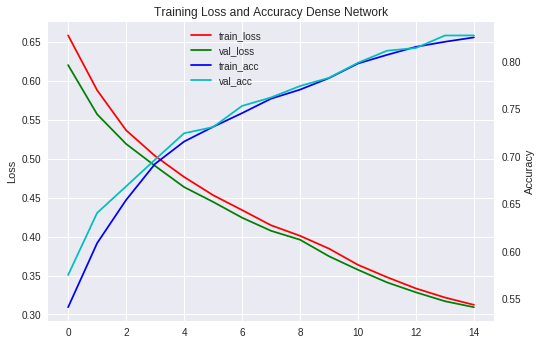

100000/100000 [==============================] - 6s 58us/sample - loss: 0.3124 - acc: 0.8252 - val_loss: 0.3093 - val_acc: 0.8273


In [5]:
dense.compile(loss=keras.losses.BinaryCrossentropy(),metrics=['acc'])
dense.fit(X,Y,epochs=15,verbose=1,callbacks=[TrainingPlot("Dense Network")],validation_data=(X_val,Y_val))

We can see that our model is very complex (3,221 trainable parameters). It was also trained with a large data set of 100K samples. Seems like this should be more then enough to learn a simple function like bitwise addition. But surprisingly, we did not reach a very high accuracy score even after 15 epochs. We seem to have reached a limit of accuracy at about 0.8. Here accuracy is the ratio of correctly classified bits out of the validation set (of 10,000*21 bits). What could be causing this?

To get a feel for the answer, it can help to look at the accuracy at each bit position (digit). This is done by the one-liner below (isn't pandas great?):

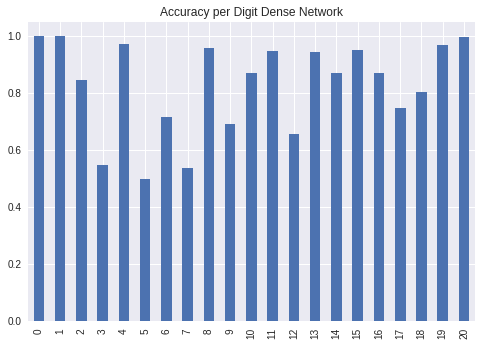

In [6]:
pd.DataFrame(Y_val==dense.predict(X_val).round(0)).mean().plot.bar(title='Accuracy per Digit Dense Network')

We see that at some positions the accuracy is close to 1, while at other positions accuracy is no better then a flip of a coin. Why is that?
* The least significant bits $Y_0$ and $Y_1$ are relatively easy to model, as they depend on smaller input. Namely, $Y_0$ depends on $X^0_0$ and $X^1_0$ only. 
* The most significant bit $Y_{20}$ is also easier then the rest since $X^0_{20}$ and $X^1_{20}$ always equal 0.
* The interesting part are everything in the middle. Each $Y_i$ depends on all the bits preceding it. This is why it is hard to model, even with more then 3000 levels of freedom in the model.

The main problem of the dense model is this: The relation between $Y_i$ and $X_0,...,X_i$ is very similar to the relation between $Y_{i+1}$ and $X_1,...,X_{i+1}$. Unfortunately, this attribute is not represented in any way in the structure of the network.

In a fully connected (dense) network, every input node is connected to every neuron in the hidden layer (see image below). In other words, all inputs are the same and have no additional structure. Our network can learn the relation between some inputs and the output (say the relation between $\{X^0_0,X^1_0,X^1_0,X^1_1\}$ and $Y^1$), using some neurons in the hidden layer. But this will not help at all for predicting, say, $Y_3$. In order to predict $Y_3$ the network will have to learn the relation again using different neurons.

Fortunately, convolution networks are designed with exactly this principal in mind. 

![dense](dense.png "dense")

# Modeling the data using Convolution networks

A convolution neural network (CNN) is a network design in which **the same** set of weights, the kernel, is applied to the inputs in a "sliding window" fashion. This produces an output with similar dimension as the input. See the image below for an illustration.

Although usually applied to images, this structure is most relevant in our case. It allows the network to model the relation between input and output, say the relation between $\{X^0_{i-1},X^1_i,X^1_{i-1},X^1_i\}$ and $Y^i$ using the same kernel, and apply it to all $i$.

Below is a simple CNN design, interpreting our input $X_i$ a $2 \times 21$ "image", and applying 8 kernels of size $2 \times 3$. 
![conv](conv.png "conv")

In [12]:
cnn = keras.Sequential([
    keras.layers.Input(shape=(M+1,2)),
    keras.layers.Reshape((M+1,2,1)), # Technicality. Treat input as a single chanel image.
    keras.layers.Conv2D(8,(3,2),activation='relu'),
    keras.layers.Conv2D(4,(3,1),activation='relu'), # Not really neccessary. Reduces dimention.
    Flatten(),
    Dense(M+1, activation='sigmoid', name="Output")
], name='CNN')
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 21, 2, 1)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 1, 8)          56        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 1, 4)          100       
_________________________________________________________________
flatten_2 (Flatten)          (None, 68)                0         
_________________________________________________________________
Output (Dense)               (None, 21)                1449      
Total params: 1,605
Trainable params: 1,605
Non-trainable params: 0
_________________________________________________________________


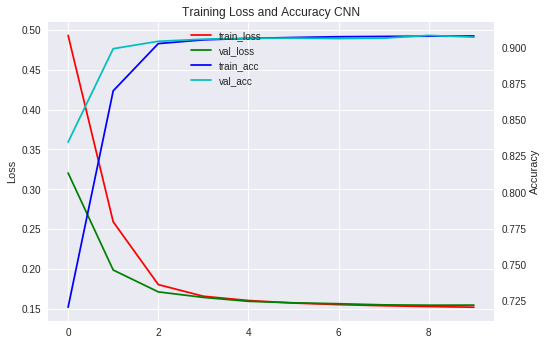

100000/100000 [==============================] - 7s 70us/sample - loss: 0.1519 - acc: 0.9080 - val_loss: 0.1546 - val_acc: 0.9072


In [9]:
cnn.compile(loss=keras.losses.BinaryCrossentropy(),metrics=['acc'])
cnn.fit(X,Y,epochs=10,verbose=1,callbacks=[TrainingPlot('CNN')],validation_data=(X_val,Y_val))

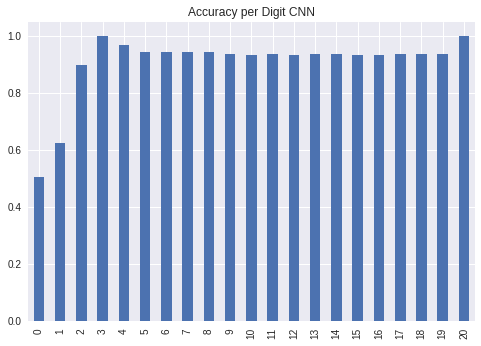

In [10]:
pd.DataFrame(Y_val==cnn.predict(X_val).round(0)).mean().plot.bar(title='Accuracy per Digit CNN')

Seems the CNN works very well on most digits. However for some  reason it has poor performance on the first digits. Why can this be? Recall that in a CNN the **same** kernel is applied to all positions, in a sliding window fashion. Unfortunately, the first positions (mostly $X_0$) do not fall in the same "windows" as the rest of the positions. This is hard for the network to model.

Fortunately, keras has a built in solution for this. By using a "padded" version of the same layer, the input is padded with zeros, to produce output with same dimensionality as the input. Again this method, usually applied to images, is perfectly aligned with our case. 

In [14]:
cnn_padding = keras.Sequential([
    keras.layers.Input(shape=(M+1,2)),
    keras.layers.Reshape((M+1,2,1)), # Technicality. Treat input as a single chanel image.
    keras.layers.Conv2D(8,(3,2),activation='relu',padding='same'),
    keras.layers.Conv2D(4,(3,1),activation='relu',padding='same'),
    Flatten(),
    Dense(M+1, activation='sigmoid', name="Output")
])

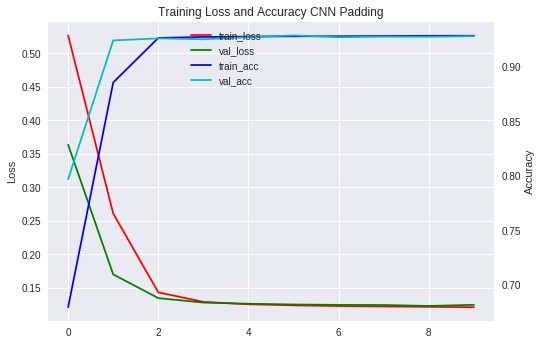

100000/100000 [==============================] - 8s 82us/sample - loss: 0.1209 - acc: 0.9283 - val_loss: 0.1244 - val_acc: 0.9279


In [15]:
cnn_padding.compile(loss=keras.losses.BinaryCrossentropy(),metrics=['acc'])
cnn_padding.fit(X,Y,epochs=10,verbose=1,callbacks=[TrainingPlot('CNN Padding')],validation_data=(X_val,Y_val))

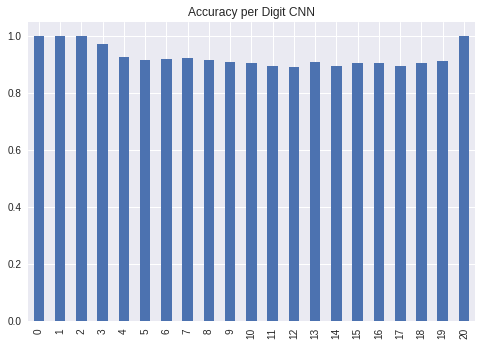

In [16]:
pd.DataFrame(Y_val==cnn_padding.predict(X_val).round(0)).mean().plot.bar(title='Accuracy per Digit CNN')

Looks like accuracy is improved and is consistent across positions. But Something is still missing. Consider bitwise addition as a boolean function. It is actually an extremely simple 3 bit function:
$$Y_i = (X^0_i + X^1_i + CO_i) \mod 2$$ 
where $CO_i$ is the "carry over" bit from the previous digits.

The thing is that $CO$ as a function of the input is a **recursive function**:
$$CO_0 = 0; {    }CO_i = (X^0_i + X^1_i + CO_{i-1}) \div 2$$

It is this "recursive" or "ordered" notion that is missing in the CNN, and for that matter in any Feed Forward network. Namely, the network is operating on the entire input at once, and is unaware of any "state" it may save from $X_0$ when operating on $X_{20}$.

This is where RNNs comes to our help.

# Modeling the data using a Recurrent network

Recurrent Neural Networks (RNN) are a network design in which the input is treated as a time series. The time dimension may have any size, and the input dimension is determined only by the number of new inputs added at each time-stamp. An RNN may have a number of hidden neurons, which are interpreted as "state" or "memory" units. At each time-stamp $t$ the state of the unit is passed as input to the next stage and determines the state it time-stamp $t+1$ (see the illustration below).

In our case, the input digits can be thought off as a time series dataset where at each time-stamp $t$ exactly two inputs $X^0_t$ and $X^1_t$ are passed.

![rnn](rnn.png "rnn")

In [18]:
def RNN(units, M=M):
    return keras.Sequential([
        Input(shape=(M+1,2), name='Input'),
        SimpleRNN(units=units, return_sequences=True, name='RNN'),
        TimeDistributed(Dense(1), name='Output')
    ], name=f"RNN_{M}")

We can see that the network architecture is completely independent of M, the number of digits in our input:

In [19]:
print(RNN(10,21).summary())
print()
print(RNN(10,1000).summary())

Model: "RNN_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 22, 10)            130       
_________________________________________________________________
Output (TimeDistributed)     (None, 22, 1)             11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
None

Model: "RNN_1000"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 1001, 10)          130       
_________________________________________________________________
Output (TimeDistributed)     (None, 1001, 1)           11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
None


With this simple RNN architecture we can perfectly model both training and validation sets using a model with only 141 trainable parameters:

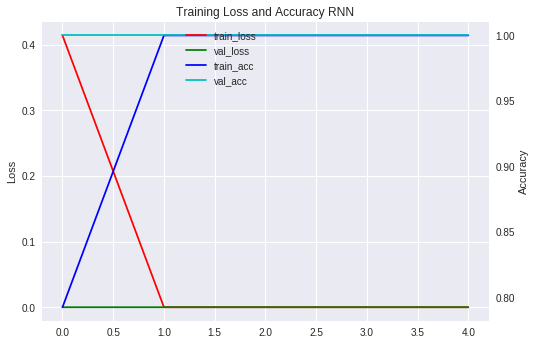

100000/100000 [==============================] - 21s 214us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [32]:
rnn = RNN(10)
rnn.compile(loss=keras.losses.BinaryCrossentropy(),metrics=['acc'])
rnn.fit(X,Y,epochs=5,verbose=1,callbacks=[TrainingPlot('RNN')],validation_data=(X_val,Y_val))

In fact we can use a much simpler model. Only 3 "memory" units, resulting in 22 parameters.

In [66]:
rnn_3 = RNN(3)
rnn_3.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 21, 3)             18        
_________________________________________________________________
Output (TimeDistributed)     (None, 21, 1)             4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


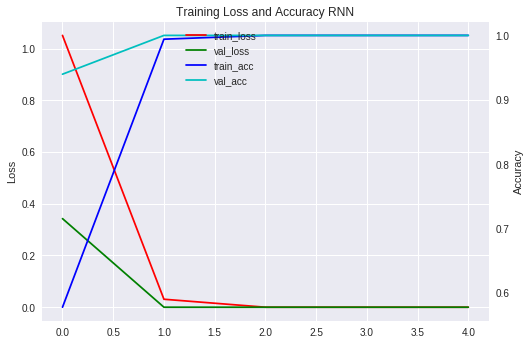

100000/100000 [==============================] - 17s 174us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [44]:
rnn_3.compile(loss=keras.losses.BinaryCrossentropy(),metrics=['acc'])
rnn_3.fit(X,Y,epochs=5,verbose=1,callbacks=[TrainingPlot('RNN')],validation_data=(X_val,Y_val))

Using only 2 memory units however is apparently not enough to perfectly model binary addition (not even given more data and training epochs). Can you explain why?

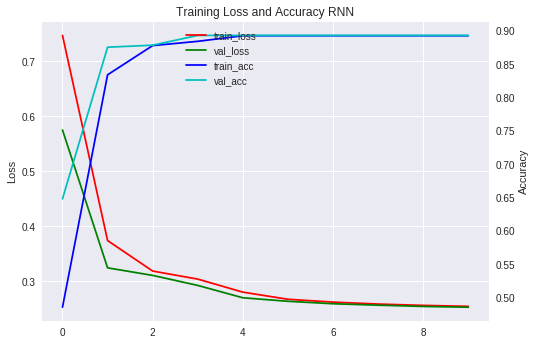

100000/100000 [==============================] - 17s 169us/sample - loss: 0.2544 - acc: 0.8928 - val_loss: 0.2529 - val_acc: 0.8933


In [45]:
rnn_2 = RNN(2)
rnn_2.compile(loss=keras.losses.BinaryCrossentropy(),metrics=['acc'])
rnn_2.fit(X,Y,epochs=10,verbose=1,callbacks=[TrainingPlot('RNN')],validation_data=(X_val,Y_val))